# TODO 

* take a look at this: [Modeling Guide for Predictive Maintenance -- Azure notebook](https://notebooks.azure.com/Microsoft/libraries/PredictiveMaintenance/html/Predictive%20Maintenance%20Modeling%20Guide%20Python%203%20Notebook.ipynb). It is quite comprehensive and might be a better model for us.

* Add IoT Hub name and use it as path throughout the notebook.
    
    `Issue:` using the automl_setup.cmd gives an error that: <font color=red>_azureml-train-automl 0.1.80 has requirement pytz<=2018.5, but you'll have pytz 2018.7 which is incompatible._</font> Downgraded using pip install pytz==2018.5 and reran the script no error for pytz this time, but still fails for widget install
        
    `Issue:` using the automl_setup.cmd fails to install jupyter nbextension install --py azureml.train.widgets --user and command continues to fail in jupyter notebooks


# Getting started

## Generate data

Need to describe how to run the deviceharness or upload avro files to a storage account.

When setting up the routing use the this mask: {iothub}/{YYYY}/{MM}/{DD}/{HH}/{mm}/{partition} instead of the default because it will make download easier

### Set up a development environment

1. Install [miniconda](https://conda.io/miniconda.html)
1. Use the apporpriate `automl_setup*` script from [MachineLearningNotebooks](https://github.com/Azure/MachineLearningNotebooks/tree/7bb906b53c4903edf2252e8dc0ac14a322c7a253/automl) to configure conda.
1. Install [Python extension for Visual Studio Code](https://marketplace.visualstudio.com/items?itemName=ms-python.python)
1. Install [Visual Studio Code Tools for AI](https://marketplace.visualstudio.com/items?itemName=ms-toolsai.vscode-ai)
1. Open the folder containing this notebook in VS Code $^*$
1. Open VS Code and use **Ctrl-Shift-P** (Linux and Windows) or **Command-Shift-P** (Mac) to get the **Command Pallet**. Type **Python: Select Interpreter** and then select the `azure_automl` conda environment.
1. Right-click on the _turbofan.ipynb_ file and select "AI: View in Jupyter Server" from the context menu
1. In the VS Code terminal type `conda install seaborn` 

$^*$ It may take some time for VS Code to load extensions

### Create a workspace

1. Have an azure subscription where you have rights to create resources
2. Replace `my_workspace` and `azure_subscription_id` in the next cell with your azure subscription and name for your workspace
3. Execute the cell to create the workspace and write the config file

In [ ]:
from azureml.core import Workspace
workspace_name = #'my_workspace'
subscription_id = #'azure_subscription_id'
resource_group = workspace_name

ws = Workspace.create(name=workspace_name,
                      subscription_id=subscription_id,    
                      resource_group=resource_group,
                      create_resource_group=True,
                      location='eastus2' # or other supported Azure region  
                     )

ws.write_config(path='./aml_config')

### Existing workspace

To generate config.json for an existing workspace  fill in the values for `subscription_id`, `resource_group`, and `workspace_name` in the next cell and execute the cell.

In [ ]:
%%writefile ./aml_config/config.json

{
    "subscription_id": "21670d02-8dd7-48aa-8fe4-44d8cb9232bb",
    "resource_group": "mlworkspaceturbo",
    "workspace_name": "mlWorkSpaceTurbo"
}

### More details

See [Configure a development environment for Azure Machine Learning](https://aka.ms/aml-how-to-configure-environment) for more details about how to configure development environments

Another good reference is [this Readme](https://github.com/Azure/MachineLearningNotebooks/blob/7bb906b53c4903edf2252e8dc0ac14a322c7a253/automl/README.md) and [this notebook](https://github.com/Azure/MachineLearningNotebooks/blob/7bb906b53c4903edf2252e8dc0ac14a322c7a253/automl/00.configuration.ipynb) to setup your environment.

### Setup notebook

Setup interactive shell to display output nicely

In [44]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

%matplotlib inline

### Configure workspace

Create a workspace object from the existing workspace. `Workspace.from_config()` reads the file **aml_config/config.json** and loads the details into an object named `ws`, which is used throughout the rest of the code in this notebook.

In [45]:
import azureml.core
import pandas as pd
from azureml.core.workspace import Workspace
from azureml.core.experiment import Experiment

if 'ws' not in globals():
    ws = Workspace.from_config()


output = {}
output['SDK version'] = azureml.core.VERSION
output['Subscription ID'] = ws.subscription_id
output['Workspace'] = ws.name
output['Resource Group'] = ws.resource_group
output['Location'] = ws.location
pd.set_option('display.max_colwidth', -1)
pd.DataFrame(data=output, index=['']).T

,
Location,westus2
Resource Group,mlworkspaceturbo
SDK version,0.1.80
Subscription ID,21670d02-8dd7-48aa-8fe4-44d8cb9232bb
Workspace,mlWorkSpaceTurbo


# Load train data

During the **Generate data** step above the training data were generated and sent to IoTHub and then routed to Azure storage using message routing. , The resulting data are stored in [Apache Avro](https://avro.apache.org/docs/current/)(avro) format. Here is an example deserialized record from the avro file. 

```json 
{
    "EnqueuedTimeUtc": "2018-12-01T01: 16: 22.0950000Z",
    "Properties": {},
    "SystemProperties": {
        "connectionDeviceId": "Client_3",
        "connectionAuthMethod": {
            "scope": "device",
            "type": "sas",
            "issuer": "iothub",
            "acceptingIpFilterRule": null
        },
        "connectionDeviceGenerationId": "636791290544434625",
        "contentType": "application/json",
        "contentEncoding": "utf-8",
        "enqueuedTime": "2018-12-01T01: 16: 22.0950000Z"
    },
    "Body": b'{
        "CycleTime": 1,
        "OperationalSetting1": -0.0001,
        "OperationalSetting2": 0.0001,
        "OperationalSetting3": 100.0,
        "Sensor1": 518.67,
        "Sensor2": 642.03,
       //Sensor 3-19 ommitted for brevity
        "Sensor20": 38.99,
        "Sensor21": 23.296
    }
}```

Each record is a snapshot of data taken during a single operational cycle, the properties in the "Body" element represent the different variables.

The engine is operating normally at the start of each time series, and develops a fault at some point during the series. In the training set, the fault grows in magnitude until system failure (i.e. the failure point for the engine is the final cycle in the set). The remaining useful life (RUL) is therefore expressed as:

$$RUL_{current} = Cycle_{max} - Cycle_{current}$$


### Download data from storage

The first step toward creating a model for RUL is to explore the data and understand its shape. We will download the data for this purpose, realizing that in the case of larger data sets only a sample of the data would be used at this step.

#### Register storage account

The Datastore is a convenient construct associated the Workspace to upload/download data, and interact with it from remote compute targets. Register the Azure Storage account and container where device data was routed by IoT Hub. All of the properties refer to the Azure Storage account used as a IoT Hub Custom Endpoint in the **Generate data** step above
* `account_name` name of the target Azure Storage account
* `container_name` name of the target Azure Storage container
* `account_key` either of the _Access keys_ for target Azure Storage account 


In [46]:
from azureml.core import Datastore

ds = Datastore.register_azure_blob_container(workspace=ws,
                                             datastore_name='turbofan',
                                             container_name='turbofan',
                                             account_name='mlworkspacetur2050103978',
                                             account_key='J/cwWnK0Crnb/eBrMm3uIBEO3y4/Kv1AkqAkCIMd5GdpGfeaO3arFXQn/eAOXatSsGpF8WrZQjHpuAzr6V2+Pg==',
                                             create_if_not_exists=False)

#### Use Datastore to download data

Use the Datastore to download the files to the local machine. The prefix is the top level path to download, which should be the name of the IoT Hub. 

In [47]:
ds.download(target_path="./data/download", prefix='markmydIotHubTwo/2018/12/03')

Path already exists. Skipping download for ./data/download\markmydIotHubTwo/2018/12/03/23/29/00
Path already exists. Skipping download for ./data/download\markmydIotHubTwo/2018/12/03/23/29/01
Path already exists. Skipping download for ./data/download\markmydIotHubTwo/2018/12/03/23/31/00
Path already exists. Skipping download for ./data/download\markmydIotHubTwo/2018/12/03/23/31/01
Path already exists. Skipping download for ./data/download\markmydIotHubTwo/2018/12/03/23/33/00
Path already exists. Skipping download for ./data/download\markmydIotHubTwo/2018/12/03/23/33/01
Path already exists. Skipping download for ./data/download\markmydIotHubTwo/2018/12/03/23/35/00
Path already exists. Skipping download for ./data/download\markmydIotHubTwo/2018/12/03/23/35/01
Path already exists. Skipping download for ./data/download\markmydIotHubTwo/2018/12/03/23/37/00
Path already exists. Skipping download for ./data/download\markmydIotHubTwo/2018/12/03/23/37/01
Path already exists. Skipping download f

0

### Create utils for loading data from avro files

Define a set of utility methods for loading the data from the avro files. We will use these on the downloaded data and later these utilities will form the basis of data processing for remote training (see **Train regression using Azure AutoMl and remote execution** below)

In [48]:
%%writefile ./utils.py

import glob
import json
import pandas as pd

from fastavro import reader
from os.path import isfile

# parse connectionDeviceId and return the int part
# (e.g. Client_1 becomes 1)
def get_unit_num (unit_record):
    unit = unit_record["connectionDeviceId"]
    return int(unit.split('_')[1])

# create data row from avro file record
def load_cycle_row(record):
    json_body = record["Body"].decode()
    row = json.loads(json_body)
    row.update({'Unit': get_unit_num(record["SystemProperties"])})
    row.update({'QueueTime': pd.to_datetime(record["EnqueuedTimeUtc"])})
    return row

# add row to data frame
def append_df(base_df, append_df):
    if(base_df is None):
        base_df = pd.DataFrame(append_df)
    else:
        base_df = base_df.append(append_df, ignore_index=True)
    return base_df

# sort rows and columns in dataframe
def sort_and_index(index_data):
    #sort rows and reset index
    index_data.sort_values(by=['Unit', 'CycleTime'], inplace=True)
    index_data.reset_index(drop=True, inplace=True)
    
    #fix up column sorting for convenience in notebook
    sorted_cols = (["Unit","CycleTime", "QueueTime"] 
                   + ["OperationalSetting"+str(i) for i in range(1,4)] 
                   + ["Sensor"+str(i) for i in range(1,22)])

    return index_data[sorted_cols]

# load data from an avro file and return a dataframe
def load_avro_file(avro_file_name):
    with open(avro_file_name, 'rb') as fo:
        file_df = None
        avro_reader = reader(fo)
        print ("load records from file: %s" % avro_file_name)
        for record in avro_reader:
            row = load_cycle_row(record)
            file_df = append_df(base_df=file_df, append_df=[row])
        return file_df

# load data from all avro files in given dir 
def load_avro_directory(avro_dir_name):
    dir_df = None
    for file_name in glob.iglob(avro_dir_name, recursive=True):
        if isfile(file_name):
            file_df = load_avro_file(file_name)
            dir_df = append_df(base_df=dir_df, append_df=file_df)
    print("loaded %d records" % dir_df.shape[0])
    return sort_and_index(dir_df)

# add max cycle to each row in the data
def add_maxcycle(data_frame):
    # cleanup column if it already exists
    if 'MaxCycle' in data_frame.columns:
        data_frame.drop('MaxCycle', axis=1, inplace=True)

    total_cycles = data_frame.groupby(['Unit']).agg({'CycleTime' : 'max'}).reset_index()
    total_cycles.rename(columns = {'CycleTime' : 'MaxCycle'}, inplace = True)
    return data_frame.merge(total_cycles, how = 'left', left_on = 'Unit', right_on = 'Unit')

# return a remaining useful life class based on RUL
def classify_rul(rul):
     if (rul <= 25):
          return 'F25'
     elif (rul <= 75):
          return 'F75'
     elif (rul <= 150):
          return 'F150'
     else:
          return 'Full'
    
# add remaining useful life and remaing useful life class
# to each row in the data
def add_rul(data_frame):
    data_frame = add_maxcycle(data_frame)
    
    if 'RUL' in data_frame.columns:
        data_frame.drop('RUL', axis=1, inplace=True)
    data_frame['RUL'] = data_frame.apply(lambda r: int(r['MaxCycle'] - r['CycleTime']), axis = 1)

    if 'RulClass' in data_frame.columns:
        data_frame.drop('RulClass', axis=1, inplace=True)
    data_frame['RulClass'] = data_frame.apply(lambda r: classify_rul(r['RUL']), axis = 1)
    
    return data_frame



Overwriting ./utils.py


### Use utils to load data from download directory

In [33]:
import utils

train_pd =  utils.load_avro_directory('.\\data\\download\\**\\*')

train_pd.head(5)

load records from file: .\data\download\markmydIotHubTwo\2018\12\03\23\29\00
load records from file: .\data\download\markmydIotHubTwo\2018\12\03\23\29\01
load records from file: .\data\download\markmydIotHubTwo\2018\12\03\23\31\00
load records from file: .\data\download\markmydIotHubTwo\2018\12\03\23\31\01
load records from file: .\data\download\markmydIotHubTwo\2018\12\03\23\33\00
load records from file: .\data\download\markmydIotHubTwo\2018\12\03\23\33\01
load records from file: .\data\download\markmydIotHubTwo\2018\12\03\23\35\00
load records from file: .\data\download\markmydIotHubTwo\2018\12\03\23\35\01
load records from file: .\data\download\markmydIotHubTwo\2018\12\03\23\37\00
load records from file: .\data\download\markmydIotHubTwo\2018\12\03\23\37\01
load records from file: .\data\download\markmydIotHubTwo\2018\12\03\23\39\00
load records from file: .\data\download\markmydIotHubTwo\2018\12\03\23\39\01
load records from file: .\data\download\markmydIotHubTwo\2018\12\03\23\41\00

,Unit,CycleTime,QueueTime,OperationalSetting1,OperationalSetting2,OperationalSetting3,Sensor1,Sensor2,Sensor3,Sensor4,...,Sensor12,Sensor13,Sensor14,Sensor15,Sensor16,Sensor17,Sensor18,Sensor19,Sensor20,Sensor21
0,1,1,2018-12-03 23:29:09.850,42.0049,0.8400,100.0,445.00,549.68,1343.43,1112.93,...,129.78,2387.99,8074.83,9.3335,0.02,330.0,2212.0,100.00,10.62,6.3670
1,1,2,2018-12-03 23:29:10.945,20.0020,0.7002,100.0,491.19,606.07,1477.61,1237.50,...,312.59,2387.73,8046.13,9.1913,0.02,361.0,2324.0,100.00,24.37,14.6552
2,1,3,2018-12-03 23:29:11.980,42.0038,0.8409,100.0,445.00,548.95,1343.12,1117.05,...,129.62,2387.97,8066.62,9.4007,0.02,329.0,2212.0,100.00,10.48,6.4213
3,1,4,2018-12-03 23:29:13.028,42.0000,0.8400,100.0,445.00,548.70,1341.24,1118.03,...,129.80,2388.02,8076.05,9.3369,0.02,328.0,2212.0,100.00,10.54,6.4176
4,1,5,2018-12-03 23:29:14.060,25.0063,0.6207,60.0,462.54,536.10,1255.23,1033.59,...,164.11,2028.08,7865.80,10.8366,0.02,305.0,1915.0,84.93,14.03,8.6754


### Calculate remaining useful life and RUL class labels

Add RUL for regression training and RulClass for classification

In [34]:
train_pd = utils.add_rul(train_pd)

cols = ['Unit', 'CycleTime', 'MaxCycle', 'RUL', 'RulClass']
#show first 5 rows
train_pd[cols].head(5)

#show last 5 rows for engine 3
train_pd[train_pd['Unit'] == 3][cols].tail(5)

,Unit,CycleTime,MaxCycle,RUL,RulClass
0,1,1,321,320,Full
1,1,2,321,319,Full
2,1,3,321,318,Full
3,1,4,321,317,Full
4,1,5,321,316,Full


,Unit,CycleTime,MaxCycle,RUL,RulClass
922,3,303,307,4,F25
923,3,304,307,3,F25
924,3,305,307,2,F25
925,3,306,307,1,F25
926,3,307,307,0,F25


### Display train data

In [49]:
train_pd.head(5)

,Unit,CycleTime,QueueTime,OperationalSetting1,OperationalSetting2,OperationalSetting3,Sensor1,Sensor2,Sensor3,Sensor4,...,Sensor15,Sensor16,Sensor17,Sensor18,Sensor19,Sensor20,Sensor21,MaxCycle,RUL,RulClass
0,1,1,2018-12-03 23:29:09.850,42.0049,0.8400,100.0,445.00,549.68,1343.43,1112.93,...,9.3335,0.02,330.0,2212.0,100.00,10.62,6.3670,321,320,Full
1,1,2,2018-12-03 23:29:10.945,20.0020,0.7002,100.0,491.19,606.07,1477.61,1237.50,...,9.1913,0.02,361.0,2324.0,100.00,24.37,14.6552,321,319,Full
2,1,3,2018-12-03 23:29:11.980,42.0038,0.8409,100.0,445.00,548.95,1343.12,1117.05,...,9.4007,0.02,329.0,2212.0,100.00,10.48,6.4213,321,318,Full
3,1,4,2018-12-03 23:29:13.028,42.0000,0.8400,100.0,445.00,548.70,1341.24,1118.03,...,9.3369,0.02,328.0,2212.0,100.00,10.54,6.4176,321,317,Full
4,1,5,2018-12-03 23:29:14.060,25.0063,0.6207,60.0,462.54,536.10,1255.23,1033.59,...,10.8366,0.02,305.0,1915.0,84.93,14.03,8.6754,321,316,Full


# Train model using Azure AutoMl and remote execution

In this section, we will use the Azure Machine Learning service to build a model to predict remaining useful life.

###  Create remote compute target

Azure ML Managed Compute is a managed service that enables data scientists to train machine learning models on clusters of Azure virtual machines, including VMs with GPU support. This code creates an Azure Managed Compute cluster if it does not already exist in your workspace. 

 **Creation of the cluster takes approximately 5 minutes.** If the cluster is already in the workspace this code uses it and skips the creation process.

In [50]:
from azureml.core.compute import AmlCompute
from azureml.core.compute import BatchAiCompute
from azureml.core.compute import ComputeTarget
import os

CLUSTER_NAME = "mlturbo"

# choose a name for your cluster
batchai_cluster_name = os.environ.get("BATCHAI_CLUSTER_NAME", CLUSTER_NAME + "gpu")
cluster_min_nodes = os.environ.get("BATCHAI_CLUSTER_MIN_NODES", 1)
cluster_max_nodes = os.environ.get("BATCHAI_CLUSTER_MAX_NODES", 3)
vm_size = os.environ.get("BATCHAI_CLUSTER_SKU", "STANDARD_NC6")
autoscale_enabled = os.environ.get("BATCHAI_CLUSTER_AUTOSCALE_ENABLED", True)

if batchai_cluster_name in ws.compute_targets:
    compute_target = ws.compute_targets[batchai_cluster_name]
    if compute_target and compute_target.type == 'BatchAI':
        print('found compute target. just use it. ' + batchai_cluster_name)
else:
    print('creating a new compute target...')
    provisioning_config = AmlCompute.provisioning_configuration(vm_size = vm_size, # NC6 is GPU-enabled
                                                                vm_priority = 'lowpriority', # optional
                                                                autoscale_enabled = autoscale_enabled,
                                                                min_nodes = cluster_min_nodes, 
                                                                max_nodes = cluster_max_nodes)

    # create the cluster
    compute_target = ComputeTarget.create(ws, batchai_cluster_name, provisioning_config)
    
    # can poll for a minimum number of nodes and for a specific timeout. 
    # if no min node count is provided it will use the scale settings for the cluster
    compute_target.wait_for_completion(show_output=True, min_node_count=None, timeout_in_minutes=20)
    
     # For a more detailed view of current BatchAI cluster status, use the 'status' property    
    print(compute_target.status.serialize())

found compute target. just use it. mlturbogpu


### Configure run settings

Create a DataReferenceConfiguration object to inform the system what data folder to download to the compute target. The path_on_compute should be an absolute path to ensure that the data files are downloaded only once.  The get_data method should use the same path to access the data files.

#### Add a DataReference to storage

In [51]:
from azureml.train.automl import AutoMLConfig
from azureml.core.runconfig import DataReferenceConfiguration
dr = DataReferenceConfiguration(datastore_name=ds.name, 
                   path_on_datastore='markmydIotHubTwo', 
                   path_on_compute='/tmp/azureml_runs',
                   mode='download', # download files from datastore to compute target
                   overwrite=False)

#### Update RunConfiguration

In [52]:
from azureml.core.runconfig import RunConfiguration
from azureml.core.conda_dependencies import CondaDependencies

# create a new RunConfig object
conda_run_config = RunConfiguration(framework="python")

# Set compute target to the BatchAI compute
conda_run_config.target = compute_target

# set the data reference of the run coonfiguration
conda_run_config.data_references = {ds.name: dr}

cd = CondaDependencies.create(pip_packages=['azureml-sdk[automl]', 'fastavro'], conda_packages=['numpy'])
conda_run_config.environment.python.conda_dependencies = cd

### Create data script for classifier

In [63]:
import os
import shutil

script_folder = './turbofan-classifier'
os.makedirs(script_folder, exist_ok=True)

shutil.copyfile('utils.py', script_folder + '/get_data.py')

'./turbofan-classifier/get_data.py'

In [64]:
%%writefile -a $script_folder/get_data.py

def get_data():
    #for the sake of simplicity use all op settings and sensor measures as training features for the model
    features = ["Sensor"+str(i) for i in range(1,22)]
    train_pd = load_avro_directory('/tmp/azureml_runs/**/*')
    train_pd = add_rul(train_pd)
    y_train = train_pd['RulClass'].values
    X_train = train_pd[features].values
    return { "X" : X_train, "y" : y_train}

Appending to ./turbofan-classifier/get_data.py


### Define classifier experiment and settings

In [65]:
import logging

#name project folder and experiment
class_experiment_name = 'turbofan-classifier-remote'

automl_settings = {
    "iteration_timeout_minutes": 10,
    "iterations": 20,
    "n_cross_validations": 10,
    "primary_metric": 'AUC_weighted',
    "max_cores_per_iteration": -1,
    "enable_ensembling": True,
    "ensemble_iterations": 5,
    "verbosity": logging.INFO,
    "preprocess": True,
    "enable_tf": True,
    "auto_blacklist": True
}

Automl_config = AutoMLConfig(task = 'classification',
                             debug_log = 'auto-class.log',
                             path=script_folder,
                             run_configuration=conda_run_config,
                             data_script = script_folder + "/get_data.py",
                             **automl_settings
                            )

### Run the experiment

Run the experiment on the remote compute target and show results as the runs execute.

In [66]:
from azureml.core.experiment import Experiment
experiment_class=Experiment(ws, class_experiment_name)
classifier_run = experiment_class.submit(Automl_config, show_output=False)
classifier_run

Experiment,Id,Type,Status,Details Page,Docs Page
turbofan-classifier-remote,AutoML_2bd60ad2-f694-42bd-900d-2086fea3250b,automl,Preparing,Link to Azure Portal,Link to Documentation


# Explore the results

Explore the results of the automatic training using the run details.

### Load test data

In the test set, the time series ends some time prior to system failure. The actual
remaining useful life (RUL) are given in the RUL_*.txt files.  The data in the RUL files is a single vector where the index corresponds to the unit number of the engine and the value corresponds to the actual RUL at the end of the test.

The RUL for a given cycle in the training set is given by adding the RUL at test end (from the RUL vector file) to the maximum cycle in the test data and then subtracting the current cycle:

$$RUL_{current} =  RUL_{TestEnd} + Cycle_{max} - Cycle_{current}$$

Taking unit number 1 as an example:
   * Taking the first value from RUL_FD003.txt gives:       $RUL_{TestEnd} = 44$
   * The final(max) cycle value from test_FD003.txt gives:  $Cycle_{max} = 233$
   * The values for the first 5 cycles for engine 1 are:

|Unit|Cycle|Max Cycle|Test End RUL|Remaining Life|
|-----|-----|-----|-----|-----|
|1|1|233|44|276|
|1|2|233|44|275|
|1|3|233|44|274|
|1|4|233|44|273|
|1|5|233|44|272|


#### Define some methods for loading from text files

In [67]:
import json
import pandas as pd
from os.path import isfile

def add_column_names(data_frame):
    data_frame.columns = (["Unit","CycleTime"]
                          + ["OperationalSetting"+str(i) for i in range(1,4)]
                          + ["Sensor"+str(i) for i in range(1,22)])

def read_data_file(full_file_name):
    data = pd.read_csv(full_file_name, sep = ' ', header = None)
    data.dropna(axis='columns', inplace=True)
    return data

def load_rul_data(full_file_name):
    rul_data = read_data_file(full_file_name)

    # add a column for the unit and fill with numbers 1..n where
    # n = number of rows of RUL data
    rul_data['Unit'] = list(range(1, len(rul_data) + 1))
    rul_data.rename(columns = {0 : 'TestEndRUL'}, inplace = True)
    return rul_data


def load_test_data(test_full_file_name, rul_full_file_name):
    data = read_data_file(test_full_file_name)
    add_column_names(data)
    data = utils.add_maxcycle(data)
    
    rul_data = load_rul_data(rul_full_file_name)
    data = data.merge(rul_data, how = 'left', left_on = 'Unit', right_on = 'Unit')
    data['RUL'] = data.apply(lambda r: int(r['MaxCycle'] + r['TestEndRUL'] - r['CycleTime']), axis = 1)
    data['RulClass'] = data.apply(lambda r: utils.classify_rul(r['RUL']), axis = 1)

    return data


#### Read and process the test data

In [68]:
dataset = "FD004"
rul_file_name = 'data/RUL_' + dataset + '.txt'
test_file_name = 'data/test_' + dataset + '.txt'

test_pd = load_test_data(test_file_name, rul_file_name)
test_pd.head(5)

,Unit,CycleTime,OperationalSetting1,OperationalSetting2,OperationalSetting3,Sensor1,Sensor2,Sensor3,Sensor4,Sensor5,...,Sensor16,Sensor17,Sensor18,Sensor19,Sensor20,Sensor21,MaxCycle,TestEndRUL,RUL,RulClass
0,1,1,20.0072,0.7000,100.0,491.19,606.67,1481.04,1227.81,9.35,...,0.02,362,2324,100.00,24.31,14.7007,230,22,251,Full
1,1,2,24.9984,0.6200,60.0,462.54,536.22,1256.17,1031.48,7.05,...,0.02,306,1915,84.93,14.36,8.5748,230,22,250,Full
2,1,3,42.0000,0.8420,100.0,445.00,549.23,1340.13,1105.88,3.91,...,0.02,328,2212,100.00,10.39,6.4365,230,22,249,Full
3,1,4,42.0035,0.8402,100.0,445.00,549.19,1339.70,1107.26,3.91,...,0.02,328,2212,100.00,10.56,6.2367,230,22,248,Full
4,1,5,35.0079,0.8400,100.0,449.44,555.10,1353.04,1117.80,5.48,...,0.02,333,2223,100.00,14.85,8.9326,230,22,247,Full


## Test classifier


### Reconstitute a run
To retrieve the run from the run id use `AutoMLRun` from `azureml.train.automl.run`

<font color=gray>_Note: there is no need to run the next cell if_</font> `classifier_run` <font color=gray>_is still in memory_</font>

In [69]:
from azureml.train.automl.run import AutoMLRun

class_experiment_name = 'turbofan-classifier-remote'
experiment_class=Experiment(ws, experiment_name)

if 'classifier_run' not in globals():
    classifier_run = AutoMLRun(experiment = experiment_class, 
                               run_id = 'AutoML_XXXXXXXX-XXXX-XXXX-XXXX-XXXXXXXXXXXX')

classifier_run.id

'AutoML_2bd60ad2-f694-42bd-900d-2086fea3250b'

### Retrieve all iterations

View the experiment history and see individual metrics for each iteration run.

In [70]:
children = list(classifier_run.get_children())
metricslist = {}
for run in children:
    properties = run.get_properties()
    metrics = {k: v for k, v in run.get_metrics().items() if isinstance(v, float)}
    metricslist[int(properties['iteration'])] = metrics

import pandas as pd
rundata = pd.DataFrame(metricslist).sort_index(1)
rundata

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
AUC_macro,0.882116,0.866698,0.856914,0.757708,0.883169,0.634550,NaN,0.889373,0.798831,0.877393,0.683035,0.814763,0.871664,0.822735,0.860751,0.883326,0.693985,0.839011,0.725066,0.890174
AUC_micro,0.902617,0.886778,0.872553,0.785852,0.903135,0.587223,NaN,0.908814,0.808524,0.898069,0.656278,0.830121,0.892401,0.843311,0.882944,0.902803,0.731953,0.837630,0.748071,0.909491
AUC_weighted,0.858405,0.841240,0.830504,0.726036,0.859842,0.615467,NaN,0.866881,0.775754,0.853113,0.656875,0.789736,0.847616,0.797740,0.836622,0.860536,0.671651,0.813527,0.695916,0.867850
AUC_weighted_max,0.858405,0.858405,0.858405,0.858405,0.859842,0.859842,NaN,0.866881,0.866881,0.866881,0.866881,0.866881,0.866881,0.866881,0.866881,0.866881,0.866881,0.866881,0.866881,0.867850
accuracy,0.667864,0.649170,0.615226,0.524776,0.670689,0.280119,NaN,0.681350,0.500612,0.661611,0.377900,0.551242,0.654754,0.564826,0.636059,0.670819,0.427582,0.559813,0.451713,0.682428
average_precision_score_macro,0.728970,0.695349,0.677159,0.511217,0.728597,0.385720,NaN,0.743084,0.525601,0.717505,0.446673,0.565497,0.703182,0.604411,0.685303,0.725938,0.445018,0.626832,0.459364,0.744317
average_precision_score_micro,0.739317,0.692424,0.666253,0.536735,0.739519,0.328773,NaN,0.753612,0.559795,0.727145,0.387119,0.584048,0.712401,0.622406,0.697799,0.737132,0.456279,0.607565,0.484866,0.754650
average_precision_score_weighted,0.700871,0.668706,0.650664,0.501195,0.701706,0.396925,NaN,0.715099,0.542701,0.690318,0.446704,0.569947,0.679692,0.596667,0.664263,0.701449,0.449679,0.614521,0.461623,0.716997
balanced_accuracy,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
f1_score_macro,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Register the best model 

Use the `regression_run` object to get the best model and register it into the workspace. 

In [71]:
best_run, fitted_model = classifier_run.get_output()

# register model in workspace
description = 'Aml Model ' + classifier_run.id[7:15]
tags = None
classifier_run.register_model(description=description, tags=tags)
classifier_run.model_id # Use this id to deploy the model as a web service in Azure

Registering model AutoML2bd60ad2fbest


'AutoML2bd60ad2fbest'

### Test classification model

predict on training and test set

In [73]:
selected_features = ["Sensor"+str(i) for i in range(1,22)]

#load the values used to train the model
X_train = train_pd[selected_features].values
y_train = train_pd['RulClass'].values

y_pred_train = fitted_model.predict(X_train)

train_pd['predictedClass'] = y_pred_train; 

#load the values from the test set
X_test = test_pd[selected_features].values
y_test = test_pd['RulClass'].values

#predict and calculate residual values for test
y_pred_test = fitted_model.predict(X_test)

test_pd['predictedClass'] = y_pred_test;


### Confusion matrix

Create a confusion matrix for the train set and the test set and plot on a heatmap

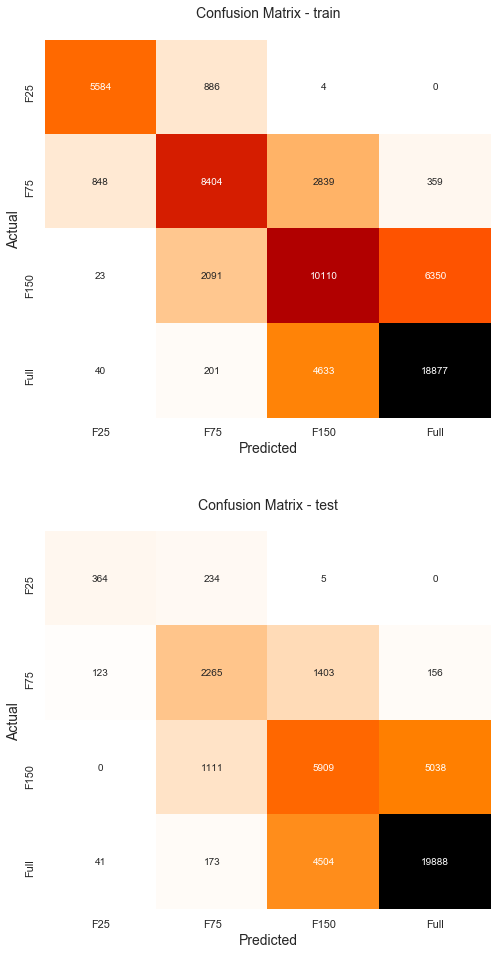

In [74]:
from pandas import DataFrame
from sklearn.metrics import confusion_matrix

index = ['F25', 'F75', 'F150','Full']
train_cfm = pd.crosstab(pd.Categorical(train_pd['RulClass'],index), 
                  pd.Categorical(train_pd['predictedClass'],index), 
                  rownames=['Actual'],
                  colnames =['Predicted'])

test_cfm = pd.crosstab(pd.Categorical(test_pd['RulClass'],index), 
                  pd.Categorical(test_pd['predictedClass'],index), 
                  rownames=['Actual'],
                  colnames =['Predicted'])

font_size = 14

fig, (ax1,ax2) = plt.subplots(nrows=2, ncols=1)
fig.set_size_inches(8, 16)
plt.subplots_adjust(hspace=.3)

ptitle = ax1.set_title('Confusion Matrix - train\n ', size=font_size)

xlabel = ax1.set_xlabel('Predicted', size=font_size)
xlabel = ax1.set_ylabel('Actual', size=font_size)

ptitle = ax2.set_title('Confusion Matrix - test\n', size=font_size)
xlabel = ax2.set_xlabel('Predicted', size=font_size)
xlabel = ax2.set_ylabel('Actual', size=font_size)

x = sns.heatmap(train_cfm, cmap='gist_heat_r', annot=True, fmt="d", cbar=False, ax=ax1)
x = sns.heatmap(test_cfm, cmap='gist_heat_r', annot=True, fmt="d", cbar=False, ax=ax2)
